# Prophet Forecasting Model for Azure Cost Management

This notebook implements Facebook's Prophet forecasting model for Azure cost prediction. Prophet is particularly well-suited for time series with strong seasonal patterns and holidays.

## Prophet Model Features
- **Additive Model**: Decomposes time series into trend, seasonality, and holidays
- **Automatic Seasonality Detection**: Handles daily, weekly, and yearly patterns
- **Holiday Effects**: Can incorporate holiday and special event effects
- **Robust to Missing Data**: Handles gaps and outliers well
- **Uncertainty Intervals**: Provides confidence intervals for predictions

## Objectives
1. Load and prepare time series data for Prophet
2. Train Prophet models for different cost categories
3. Generate forecasts with confidence intervals
4. Evaluate model performance
5. Visualize results and insights


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Prophet specific imports
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation, performance_metrics

# Load forecasting data
import pickle
with open('/Users/sabbineni/projects/acm/data/forecasting_data.pkl', 'rb') as f:
    forecasting_data = pickle.load(f)

print("Libraries imported successfully!")
print(f"Available time series: {list(forecasting_data.keys())}")

# Display data info
for key, ts_data in forecasting_data.items():
    print(f"{key}: {len(ts_data)} data points, "
          f"Date range: {ts_data.index.min()} to {ts_data.index.max()}")


Libraries imported successfully!
Available time series: ['Analytics', 'Network', 'Storage', 'Security', 'Management', 'Database', 'Compute', 'AI/ML', 'Total']
Analytics: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Network: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Storage: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Security: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Management: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Database: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Compute: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
AI/ML: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
Total: 366 data points, Date range: 2023-01-01 00:00:00 to 2024-01-01 00:00:00


In [2]:
# Prepare data for Prophet
def prepare_prophet_data(ts_data, category_name):
    """
    Prepare time series data for Prophet model.
    Prophet expects columns: 'ds' (datetime) and 'y' (values)
    """
    df_prophet = pd.DataFrame({
        'ds': ts_data.index,
        'y': ts_data.values
    })
    
    # Remove any zero or negative values (Prophet works better with positive values)
    df_prophet = df_prophet[df_prophet['y'] > 0]
    
    print(f"{category_name}: {len(df_prophet)} data points after cleaning")
    return df_prophet

# Prepare data for all categories
prophet_data = {}
for category, ts_data in forecasting_data.items():
    prophet_data[category] = prepare_prophet_data(ts_data, category)

# Display sample data
print("\nSample Prophet data format:")
display(prophet_data['Total'].head())


Analytics: 366 data points after cleaning
Network: 366 data points after cleaning
Storage: 366 data points after cleaning
Security: 366 data points after cleaning
Management: 366 data points after cleaning
Database: 366 data points after cleaning
Compute: 366 data points after cleaning
AI/ML: 366 data points after cleaning
Total: 366 data points after cleaning

Sample Prophet data format:


,ds,y
0,2023-01-01,203586.0967
1,2023-01-02,159755.1635
2,2023-01-03,274606.4270
3,2023-01-04,199121.2666
4,2023-01-05,322359.3843


In [3]:
# Train Prophet models
def train_prophet_model(data, category_name, periods=30):
    """
    Train a Prophet model for the given data.
    
    Args:
        data: DataFrame with 'ds' and 'y' columns
        category_name: Name of the category for model identification
        periods: Number of periods to forecast
    
    Returns:
        Trained model and forecast DataFrame
    """
    print(f"\nTraining Prophet model for {category_name}...")
    
    # Initialize Prophet model with custom parameters
    model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,  # Disable daily seasonality for daily data
        seasonality_mode='additive',
        changepoint_prior_scale=0.05,  # Controls trend flexibility
        seasonality_prior_scale=10.0,  # Controls seasonality strength
        holidays_prior_scale=10.0,
        interval_width=0.95,  # 95% confidence intervals
        mcmc_samples=0  # Disable MCMC for faster training
    )
    
    # Add custom seasonalities for business patterns
    model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    
    # Add holidays (optional - can be customized for business holidays)
    holidays = pd.DataFrame({
        'holiday': ['new_year', 'christmas', 'thanksgiving', 'independence_day'],
        'ds': pd.to_datetime(['2023-01-01', '2023-12-25', '2023-11-23', '2023-07-04']),
        'lower_window': 0,
        'upper_window': 1,
    })
    model.add_country_holidays(country_name='US')
    
    # Fit the model
    model.fit(data)
    
    # Make future predictions
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    print(f"Model trained successfully for {category_name}")
    print(f"Forecast shape: {forecast.shape}")
    
    return model, forecast

# Train models for key categories
key_categories = ['Total', 'Compute', 'Storage', 'Database']
prophet_models = {}
prophet_forecasts = {}

for category in key_categories:
    if category in prophet_data and len(prophet_data[category]) > 30:  # Need minimum data points
        model, forecast = train_prophet_model(prophet_data[category], category)
        prophet_models[category] = model
        prophet_forecasts[category] = forecast
    else:
        print(f"Skipping {category} - insufficient data points")

print(f"\nTrained models for: {list(prophet_models.keys())}")


19:30:08 - cmdstanpy - INFO - Chain [1] start processing



Training Prophet model for Total...


19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:09 - cmdstanpy - INFO - Chain [1] start processing
19:30:09 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully for Total
Forecast shape: (396, 64)

Training Prophet model for Compute...
Model trained successfully for Compute
Forecast shape: (396, 64)

Training Prophet model for Storage...


19:30:09 - cmdstanpy - INFO - Chain [1] start processing
19:30:09 - cmdstanpy - INFO - Chain [1] done processing
19:30:09 - cmdstanpy - INFO - Chain [1] start processing
19:30:09 - cmdstanpy - INFO - Chain [1] done processing


Model trained successfully for Storage
Forecast shape: (396, 64)

Training Prophet model for Database...
Model trained successfully for Database
Forecast shape: (396, 64)

Trained models for: ['Total', 'Compute', 'Storage', 'Database']


In [4]:
# Model Evaluation and Cross-Validation
def evaluate_prophet_model(model, data, category_name):
    """
    Evaluate Prophet model using cross-validation.
    """
    print(f"\nEvaluating Prophet model for {category_name}...")
    
    # Perform cross-validation
    df_cv = cross_validation(
        model, 
        initial='180 days',  # Initial training period
        period='30 days',    # Period between cutoff dates
        horizon='30 days',   # Forecast horizon
        parallel="threads"
    )
    
    # Calculate performance metrics
    df_performance = performance_metrics(df_cv)
    
    print(f"Cross-validation results for {category_name}:")
    print(f"RMSE: {df_performance['rmse'].mean():.2f}")
    print(f"MAE: {df_performance['mae'].mean():.2f}")
    print(f"MAPE: {df_performance['mape'].mean():.2f}")
    print(f"Coverage: {df_performance['coverage'].mean():.2f}")
    
    return df_cv, df_performance

# Evaluate models
model_evaluations = {}
for category, model in prophet_models.items():
    if len(prophet_data[category]) > 180:  # Need enough data for cross-validation
        cv_results, performance = evaluate_prophet_model(model, prophet_data[category], category)
        model_evaluations[category] = {
            'cv_results': cv_results,
            'performance': performance
        }
    else:
        print(f"Skipping evaluation for {category} - insufficient data for cross-validation")


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:33:28 - cmdstanpy - INFO - Chain [1] start processing
19:33:28 - cmdstanpy - INFO - Chain [1] start processing
19:33:28 - cmdstanpy - INFO - Chain [1] start processing
19:33:28 - cmdstanpy - INFO - Chain [1] start processing
19:33:28 - cmdstanpy - INFO - Chain [1] start processing
19:33:28 - cmdstanpy - INFO - Chain [1] done processing
19:33:28 - cmdstanpy - INFO - Chain [1] done processing



Evaluating Prophet model for Total...


19:33:28 - cmdstanpy - INFO - Chain [1] start processing
19:33:28 - cmdstanpy - INFO - Chain [1] done processing
19:33:28 - cmdstanpy - INFO - Chain [1] done processing
19:33:28 - cmdstanpy - INFO - Chain [1] done processing
19:33:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing


Cross-validation results for Total:
RMSE: 87245.87
MAE: 73664.39
MAPE: 0.50
Coverage: 0.57

Evaluating Prophet model for Compute...


19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing


Cross-validation results for Compute:
RMSE: 4469.49
MAE: 3709.57
MAPE: 0.49
Coverage: 0.67

Evaluating Prophet model for Storage...


19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
19:33:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:29 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] start processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing


Cross-validation results for Storage:
RMSE: 3158.90
MAE: 2397.82
MAPE: 0.60
Coverage: 0.59

Evaluating Prophet model for Database...


19:33:30 - cmdstanpy - INFO - Chain [1] done processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing
19:33:30 - cmdstanpy - INFO - Chain [1] done processing


Cross-validation results for Database:
RMSE: 937.07
MAE: 740.98
MAPE: 0.40
Coverage: 0.83


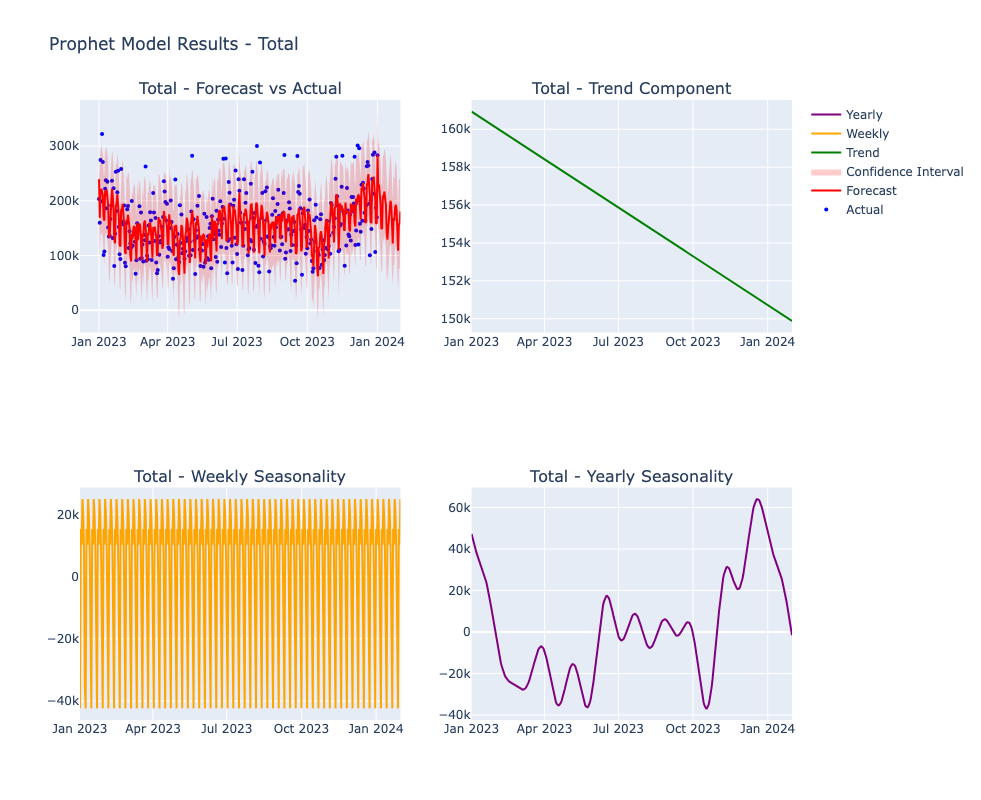

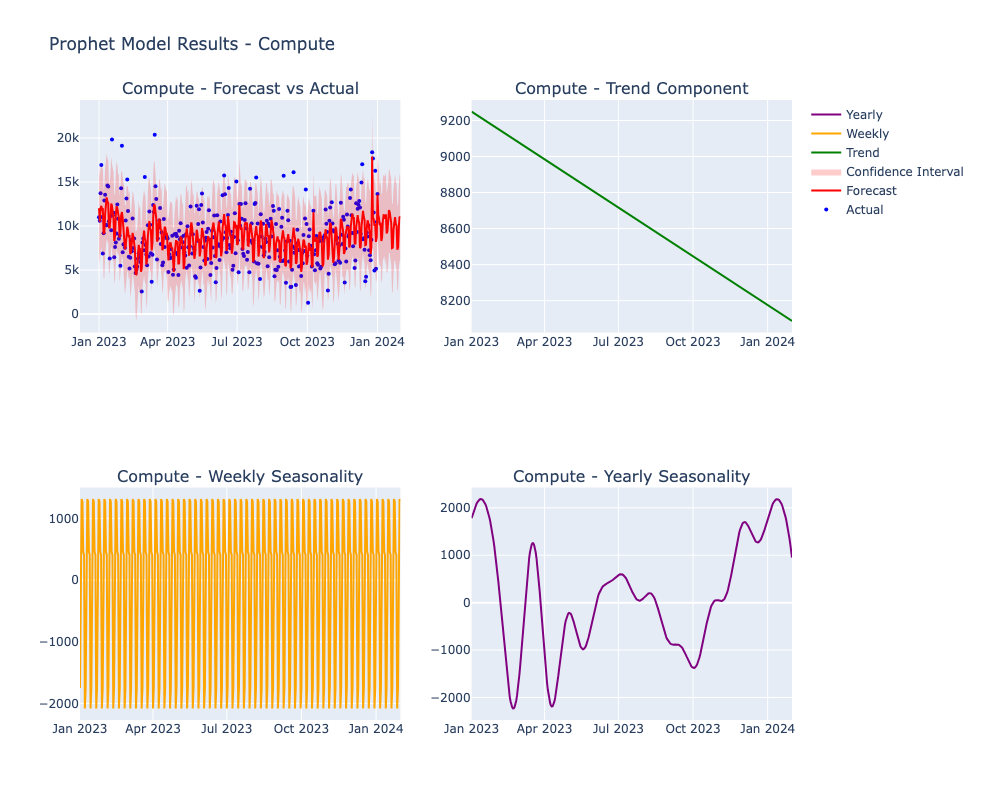

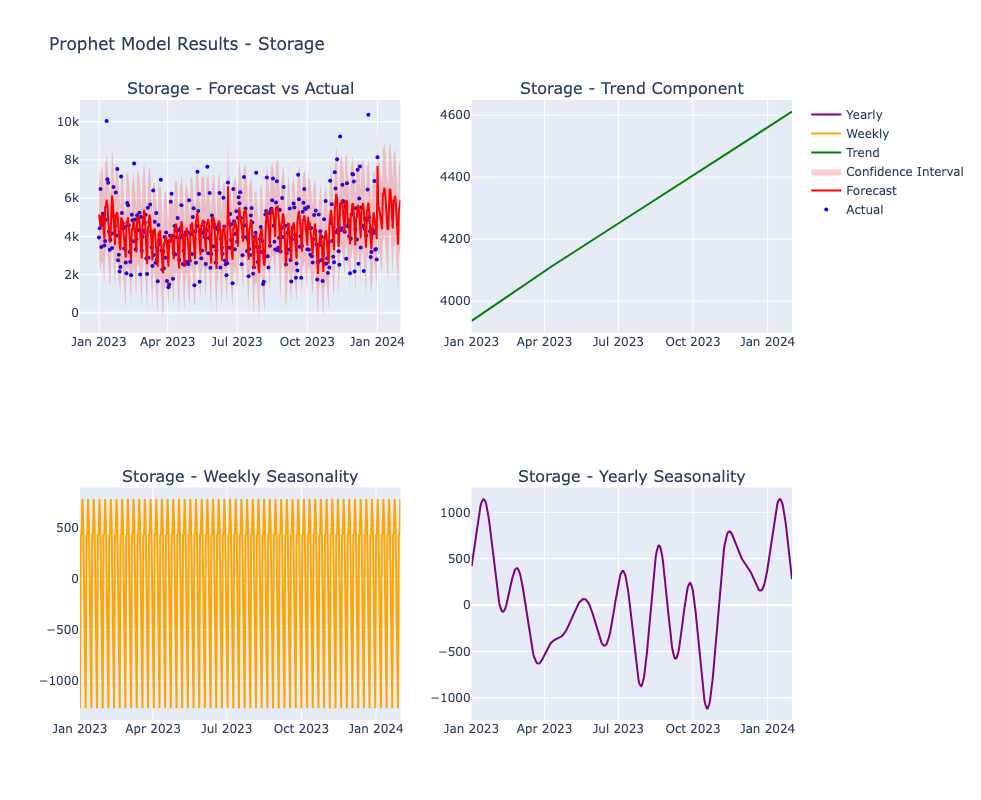

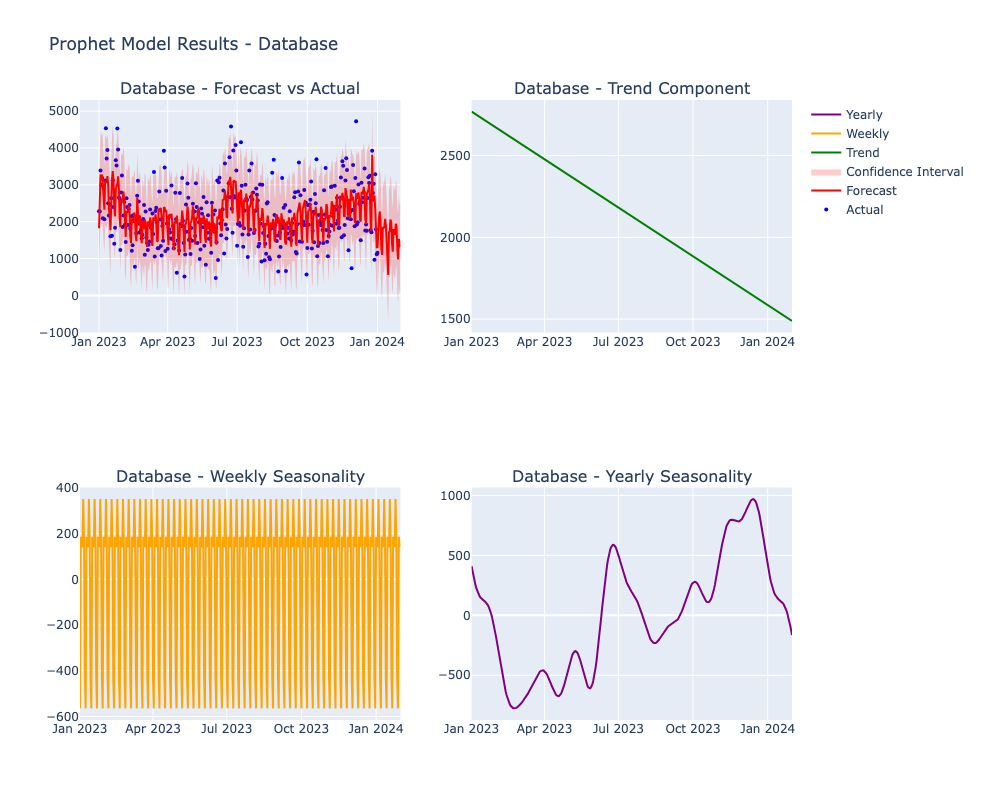

In [5]:
# Visualize Prophet Results
def plot_prophet_forecast(model, forecast, data, category_name):
    """
    Create comprehensive visualizations for Prophet model results.
    """
    # Create subplots
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            f'{category_name} - Forecast vs Actual',
            f'{category_name} - Trend Component',
            f'{category_name} - Weekly Seasonality',
            f'{category_name} - Yearly Seasonality'
        ),
        specs=[[{"secondary_y": False}, {"secondary_y": False}],
               [{"secondary_y": False}, {"secondary_y": False}]]
    )
    
    # 1. Forecast vs Actual
    fig.add_trace(
        go.Scatter(x=data['ds'], y=data['y'], mode='markers', 
                  name='Actual', marker=dict(color='blue', size=4)),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=forecast['ds'], y=forecast['yhat'], mode='lines',
                  name='Forecast', line=dict(color='red')),
        row=1, col=1
    )
    
    # Add confidence intervals
    fig.add_trace(
        go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], 
                  mode='lines', line=dict(width=0), showlegend=False),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], 
                  mode='lines', line=dict(width=0), fill='tonexty',
                  fillcolor='rgba(255,0,0,0.2)', name='Confidence Interval'),
        row=1, col=1
    )
    
    # 2. Trend component
    fig.add_trace(
        go.Scatter(x=forecast['ds'], y=forecast['trend'], mode='lines',
                  name='Trend', line=dict(color='green')),
        row=1, col=2
    )
    
    # 3. Weekly seasonality
    if 'weekly' in forecast.columns:
        fig.add_trace(
            go.Scatter(x=forecast['ds'], y=forecast['weekly'], mode='lines',
                      name='Weekly', line=dict(color='orange')),
            row=2, col=1
        )
    
    # 4. Yearly seasonality
    if 'yearly' in forecast.columns:
        fig.add_trace(
            go.Scatter(x=forecast['ds'], y=forecast['yearly'], mode='lines',
                      name='Yearly', line=dict(color='purple')),
            row=2, col=2
        )
    
    fig.update_layout(height=800, title_text=f"Prophet Model Results - {category_name}")
    fig.show()

# Create visualizations for each model
for category in prophet_models.keys():
    plot_prophet_forecast(
        prophet_models[category], 
        prophet_forecasts[category], 
        prophet_data[category], 
        category
    )


In [6]:
# Generate Future Forecasts
print("=== Future Forecasts ===")

# Generate 90-day forecasts for all models
future_forecasts = {}
forecast_periods = 90

for category, model in prophet_models.items():
    print(f"\nGenerating {forecast_periods}-day forecast for {category}...")
    
    # Create future dataframe
    future = model.make_future_dataframe(periods=forecast_periods)
    
    # Make predictions
    forecast = model.predict(future)
    
    # Extract future predictions only
    future_only = forecast[forecast['ds'] > prophet_data[category]['ds'].max()].copy()
    
    future_forecasts[category] = future_only
    
    # Display forecast summary
    print(f"Forecast period: {future_only['ds'].min()} to {future_only['ds'].max()}")
    print(f"Average predicted cost: ${future_only['yhat'].mean():.2f}")
    print(f"Total predicted cost: ${future_only['yhat'].sum():.2f}")
    print(f"Confidence interval: ${future_only['yhat_lower'].mean():.2f} - ${future_only['yhat_upper'].mean():.2f}")

# Create forecast comparison
forecast_comparison = pd.DataFrame()
for category, forecast in future_forecasts.items():
    forecast_comparison[category] = forecast['yhat'].values

forecast_comparison.index = future_forecasts['Total']['ds']
forecast_comparison.index.name = 'Date'

print(f"\nForecast comparison shape: {forecast_comparison.shape}")
print("\nSample forecast data:")
display(forecast_comparison.head())


=== Future Forecasts ===

Generating 90-day forecast for Total...
Forecast period: 2024-01-02 00:00:00 to 2024-03-31 00:00:00
Average predicted cost: $144782.50
Total predicted cost: $13030424.65
Confidence interval: $66541.02 - $223772.55

Generating 90-day forecast for Compute...
Forecast period: 2024-01-02 00:00:00 to 2024-03-31 00:00:00
Average predicted cost: $8324.32
Total predicted cost: $749188.70
Confidence interval: $3478.32 - $13166.71

Generating 90-day forecast for Storage...
Forecast period: 2024-01-02 00:00:00 to 2024-03-31 00:00:00
Average predicted cost: $4829.54
Total predicted cost: $434658.29
Confidence interval: $2439.96 - $7234.35

Generating 90-day forecast for Database...
Forecast period: 2024-01-02 00:00:00 to 2024-03-31 00:00:00
Average predicted cost: $1070.10
Total predicted cost: $96309.26
Confidence interval: $-129.65 - $2271.02

Forecast comparison shape: (90, 4)

Sample forecast data:


,Total,Compute,Storage,Database
Date,,,,
2024-01-02,222958.546223,11251.735132,5424.265153,2089.324951
2024-01-03,229706.471708,10855.648497,5547.785572,2114.930070
2024-01-04,212743.838652,10062.265679,5251.119035,2277.357987
2024-01-05,193589.310488,10388.051840,4850.789386,1994.833762
2024-01-06,150273.357407,8294.753794,4465.055777,1286.516443


In [ ]:
# Save Prophet Results
print("=== Saving Prophet Results ===")

# Save models and forecasts
import joblib
import os

# Create results directory
results_dir = '/Users/sabbineni/projects/acm/results/prophet'
os.makedirs(results_dir, exist_ok=True)

# Save models
for category, model in prophet_models.items():
    model_path = f"{results_dir}/prophet_model_{category.lower()}.pkl"
    joblib.dump(model, model_path)
    print(f"Saved model: {model_path}")

# Save forecasts
for category, forecast in prophet_forecasts.items():
    forecast_path = f"{results_dir}/prophet_forecast_{category.lower()}.csv"
    forecast.to_csv(forecast_path, index=False)
    print(f"Saved forecast: {forecast_path}")

# Save future forecasts
for category, forecast in future_forecasts.items():
    future_path = f"{results_dir}/prophet_future_{category.lower()}.csv"
    forecast.to_csv(future_path, index=False)
    print(f"Saved future forecast: {future_path}")

# Save evaluation results
if model_evaluations:
    eval_path = f"{results_dir}/prophet_evaluations.pkl"
    joblib.dump(model_evaluations, eval_path)
    print(f"Saved evaluations: {eval_path}")

# Save forecast comparison
comparison_path = f"{results_dir}/prophet_forecast_comparison.csv"
forecast_comparison.to_csv(comparison_path)
print(f"Saved forecast comparison: {comparison_path}")

print("\n✅ Prophet model implementation completed successfully!")
print("📊 Models trained, evaluated, and saved")
print("🔮 Future forecasts generated for 90 days")
print("📈 Results ready for comparison with other models")
